<h1><center>Customer Churn at Restaurant Marketplace Analysis</center></h1>

<center><img src="https://cdn.dribbble.com/users/2155131/screenshots/16416694/media/b0da9c553e7e35c242fc119de521c52f.jpg?compress=1&resize=400x300&vertical=top"></center>

<center> credit img : https://dribbble.com/shots/16416694-Steak-icon-illustration </center>

In [49]:
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

## Open Dataset

In [50]:
df = pd.read_csv('orders.csv')
df.head()

C:\Users\IDMARCO\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (15,16,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,akeed_order_id,customer_id,item_count,grand_total,payment_mode,promo_code,vendor_discount_amount,promo_code_discount_percentage,is_favorite,is_rated,...,driver_accepted_time,ready_for_pickup_time,picked_up_time,delivered_time,delivery_date,vendor_id,created_at,LOCATION_NUMBER,LOCATION_TYPE,CID X LOC_NUM X VENDOR
0,163238.0,92PEE24,1.0,7.6,2,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,105,2019-08-01 05:30:16,0,NaN,92PEE24 X 0 X 105
1,163240.0,QS68UD8,1.0,8.7,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,294,2019-08-01 05:31:10,0,Work,QS68UD8 X 0 X 294
2,163241.0,MB7VY5F,2.0,14.4,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,83,2019-08-01 05:31:33,0,NaN,MB7VY5F X 0 X 83
3,163244.0,KDJ951Y,1.0,7.1,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,90,2019-08-01 05:34:54,0,Home,KDJ951Y X 0 X 90
4,163245.0,BAL0RVT,4.0,27.2,1,NaN,0.0,NaN,NaN,No,...,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,83,2019-08-01 05:35:51,0,Work,BAL0RVT X 0 X 83


In [51]:
vendors = pd.read_csv('vendors.csv')
vendors.head()

,id,authentication_id,latitude,longitude,vendor_category_en,vendor_category_id,delivery_charge,serving_distance,is_open,OpeningTime,...,open_close_flags,vendor_tag,vendor_tag_name,one_click_vendor,country_id,city_id,created_at,updated_at,device_type,display_orders
0,4,118597.0,-0.588596,0.754434,Restaurants,2.0,0.0,6.0,1.0,11:00AM-11:30PM,...,1.0,"2,4,5,8,91,22,12,24,16,23","Arabic,Breakfast,Burgers,Desserts,Free Deliver...",Y,1.0,1.0,2018-01-30 14:42:04,2020-04-07 15:12:43,3,1
1,13,118608.0,-0.471654,0.744470,Restaurants,2.0,0.7,5.0,1.0,08:30AM-10:30PM,...,1.0,"4,41,51,34,27,15,24,16,28","Breakfast,Cakes,Crepes,Italian,Pasta,Pizzas,Sa...",Y,1.0,1.0,2018-05-03 12:32:06,2020-04-05 20:46:03,3,1
2,20,118616.0,-0.407527,0.643681,Restaurants,2.0,0.0,8.0,1.0,08:00AM-10:45PM,...,1.0,"4,8,91,10","Breakfast,Desserts,Free Delivery,Indian",Y,1.0,1.0,2018-05-04 22:28:22,2020-04-07 16:35:55,3,1
3,23,118619.0,-0.585385,0.753811,Restaurants,2.0,0.0,5.0,1.0,10:59AM-10:30PM,...,1.0,"5,8,30,24","Burgers,Desserts,Fries,Salads",Y,1.0,1.0,2018-05-06 19:20:48,2020-04-02 00:56:17,3,1
4,28,118624.0,0.480602,0.552850,Restaurants,2.0,0.7,15.0,1.0,11:00AM-11:45PM,...,1.0,5,Burgers,Y,1.0,1.0,2018-05-17 22:12:38,2020-04-05 15:57:41,3,1


## Cleaning

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135303 entries, 0 to 135302
Data columns (total 26 columns):
akeed_order_id                    135233 non-null float64
customer_id                       135303 non-null object
item_count                        128378 non-null float64
grand_total                       135303 non-null float64
payment_mode                      135303 non-null int64
promo_code                        4305 non-null object
vendor_discount_amount            135303 non-null float64
promo_code_discount_percentage    65880 non-null float64
is_favorite                       100108 non-null object
is_rated                          135303 non-null object
vendor_rating                     45220 non-null float64
driver_rating                     135303 non-null float64
deliverydistance                  135303 non-null float64
preparationtime                   79743 non-null float64
delivery_time                     5123 non-null object
order_accepted_time              

In [53]:
df['date']=df['order_accepted_time']
df.loc[df['date'].isnull()==True,'date']=df['delivery_date']
df['date'].isnull().value_counts()

False    122499
True      12804
Name: date, dtype: int64

In [54]:
#dropna for order_accepted_time
df.dropna(subset=['date','item_count'],inplace=True)
df['promo_code_discount_percentage'].fillna(0, inplace=True)
df['date']= pd.to_datetime(df['date'])
df.loc[df['is_favorite']=='Yes','favorite']=1
df.loc[df['is_favorite']=='No','favorite']=0
df['favorite'].fillna(999, inplace=True)
df['vendor_rating'].fillna(999, inplace=True)
df['preparationtime'].fillna(999, inplace=True)
df.drop(['promo_code','is_favorite','is_rated'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122451 entries, 0 to 135302
Data columns (total 25 columns):
akeed_order_id                    122434 non-null float64
customer_id                       122451 non-null object
item_count                        122451 non-null float64
grand_total                       122451 non-null float64
payment_mode                      122451 non-null int64
vendor_discount_amount            122451 non-null float64
promo_code_discount_percentage    122451 non-null float64
vendor_rating                     122451 non-null float64
driver_rating                     122451 non-null float64
deliverydistance                  122451 non-null float64
preparationtime                   122451 non-null float64
delivery_time                     4582 non-null object
order_accepted_time               86907 non-null object
driver_accepted_time              46448 non-null object
ready_for_pickup_time             84178 non-null object
picked_up_time                 

In [55]:
df['Year-Month'] = pd.to_datetime(pd.to_datetime(df['date']).dt.strftime('%Y-%m'), format='%Y-%m')
df['Year']=df['date'].dt.year
df['Month']=df['date'].dt.month
df.head(1)

,akeed_order_id,customer_id,item_count,grand_total,payment_mode,vendor_discount_amount,promo_code_discount_percentage,vendor_rating,driver_rating,deliverydistance,...,vendor_id,created_at,LOCATION_NUMBER,LOCATION_TYPE,CID X LOC_NUM X VENDOR,date,favorite,Year-Month,Year,Month
0,163238.0,92PEE24,1.0,7.6,2,0.0,0.0,999.0,0.0,0.0,...,105,2019-08-01 05:30:16,0,NaN,92PEE24 X 0 X 105,2019-07-31 05:30:00,999.0,2019-07-01,2019,7


In [56]:
df['vendor_discount_amount2']=df['vendor_discount_amount']*100

In [57]:
cust_unique = df[['customer_id','akeed_order_id']].groupby('customer_id', as_index=False).count()
df = df.merge(cust_unique, on=['customer_id'], how='left')
df.head()

,akeed_order_id_x,customer_id,item_count,grand_total,payment_mode,vendor_discount_amount,promo_code_discount_percentage,vendor_rating,driver_rating,deliverydistance,...,LOCATION_NUMBER,LOCATION_TYPE,CID X LOC_NUM X VENDOR,date,favorite,Year-Month,Year,Month,vendor_discount_amount2,akeed_order_id_y
0,163238.0,92PEE24,1.0,7.6,2,0.0,0.0,999.0,0.0,0.0,...,0,NaN,92PEE24 X 0 X 105,2019-07-31 05:30:00,999.0,2019-07-01,2019,7,0.0,4
1,163240.0,QS68UD8,1.0,8.7,1,0.0,0.0,999.0,0.0,0.0,...,0,Work,QS68UD8 X 0 X 294,2019-07-31 05:30:00,999.0,2019-07-01,2019,7,0.0,1
2,163241.0,MB7VY5F,2.0,14.4,1,0.0,0.0,999.0,0.0,0.0,...,0,NaN,MB7VY5F X 0 X 83,2019-07-31 05:30:00,999.0,2019-07-01,2019,7,0.0,4
3,163244.0,KDJ951Y,1.0,7.1,1,0.0,0.0,999.0,0.0,0.0,...,0,Home,KDJ951Y X 0 X 90,2019-07-31 05:30:00,999.0,2019-07-01,2019,7,0.0,1
4,163245.0,BAL0RVT,4.0,27.2,1,0.0,0.0,999.0,0.0,0.0,...,0,Work,BAL0RVT X 0 X 83,2019-07-31 05:30:00,999.0,2019-07-01,2019,7,0.0,8


In [58]:
df = df[df['Year']==2019]

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81508 entries, 0 to 81511
Data columns (total 30 columns):
akeed_order_id_x                  81508 non-null float64
customer_id                       81508 non-null object
item_count                        81508 non-null float64
grand_total                       81508 non-null float64
payment_mode                      81508 non-null int64
vendor_discount_amount            81508 non-null float64
promo_code_discount_percentage    81508 non-null float64
vendor_rating                     81508 non-null float64
driver_rating                     81508 non-null float64
deliverydistance                  81508 non-null float64
preparationtime                   81508 non-null float64
delivery_time                     3415 non-null object
order_accepted_time               45964 non-null object
driver_accepted_time              5618 non-null object
ready_for_pickup_time             44588 non-null object
picked_up_time                    44490 non-n

## Order Customer Distribution

In [60]:
value_customer = df['customer_id'].value_counts()
value_customer = pd.DataFrame(value_customer)

In [61]:
value_customer['count_cust']=value_customer['customer_id'].apply(lambda x : '<10' if x<10 else 
                                                                 ('10-50' if (x>=10)&(x<50) else 
                                                                  ('50-100' if (x>=50)&(x<100) else '>100')))
value_customer.head()

,customer_id,count_cust
XW90EAP,194,>100
TL7Z2DM,113,>100
VDEJEMP,94,50-100
X8BK4DW,90,50-100
HJFTTGW,88,50-100


In [62]:
count_cust = value_customer['count_cust'].value_counts()
count_cust = count_cust/count_cust.sum()*100
count_cust

<10       89.554723
10-50     10.284020
50-100     0.150853
>100       0.010404
Name: count_cust, dtype: float64

In [63]:
labels = ['<10','10-50','','']
def my_autopct(pct):
    return ('%.2f' % pct) if pct > 5 else ''
colors = ['#0504aa','#f3c33c','#255e79','#267778']

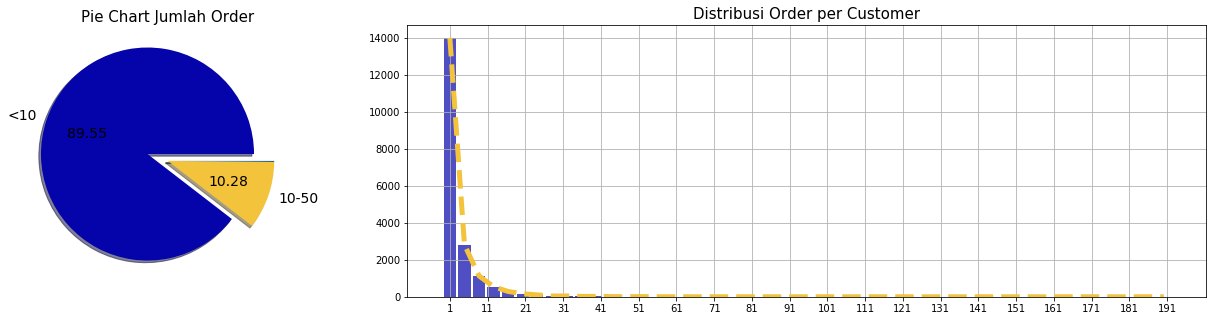

In [64]:
fig, (ax1, ax2)  = plt.subplots(1,2, figsize=(21, 5), gridspec_kw={'width_ratios': [1, 3]})

#ax1
explode = (0.2, 0, 0, 0)
ax1.pie(count_cust, explode=explode, labels=labels, autopct=my_autopct, shadow=True, 
        textprops={'fontsize': 14,'color': 'black'}, colors = colors)
ax1.set_title('Pie Chart Jumlah Order', size=15)

#ax2
n, bins, patches = ax2.hist(value_customer['customer_id'], bins=50, color='#0504aa', alpha=0.7, rwidth=0.85, align='left')

ax2.plot(bins[:50], n, '--', linewidth=5, color='#f3c33c')

ax2.grid(True)
ax2.set_title('Distribusi Order per Customer', size=15)
ax2.set_xticks(np.arange(min(value_customer['customer_id']), max(value_customer['customer_id'])+1, 10))

plt.show()

In [18]:
value_customer = pd.DataFrame(value_customer)
value_customer_50 = value_customer[value_customer['customer_id']>50]

value_customer_50['count_cust']=value_customer_50['customer_id'].apply(lambda x : '<75' if x<75 else 
                                                                       ('100-125' if (x>=100)&(x<125) else 
                                                                        ('75-100' if (x>=75)&(x<100) else '>125')))

count_cust = value_customer_50['count_cust'].value_counts()
count_cust = count_cust/count_cust.sum()*100
count_cust

C:\Users\IDMARCO\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


<75        70.967742
75-100     22.580645
100-125     3.225806
>125        3.225806
Name: count_cust, dtype: float64

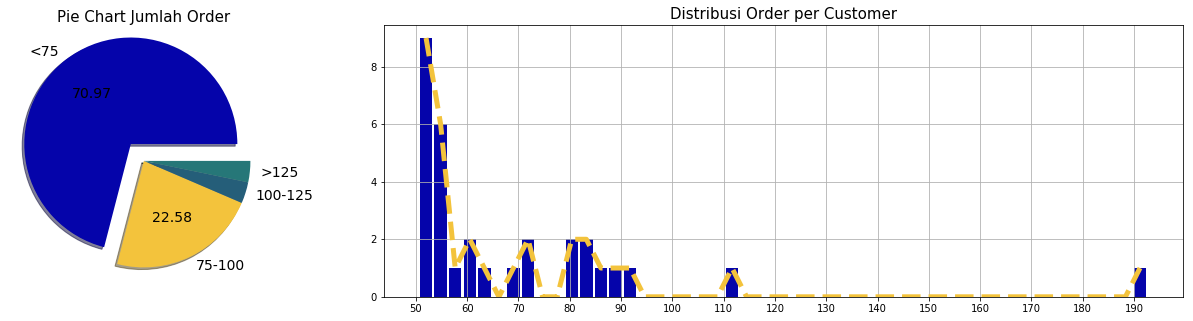

In [19]:
fig, (ax1, ax2)  = plt.subplots(1,2, figsize=(21, 5), gridspec_kw={'width_ratios': [1, 3]})

#ax1
explode = (0.2, 0, 0, 0)
ax1.pie(count_cust, explode=explode, labels=count_cust.index, autopct=my_autopct, shadow=True, 
        textprops={'fontsize': 14,'color': 'black'}, colors = colors)
ax1.set_title('Pie Chart Jumlah Order', size=15)

#ax2
n, bins, patches = ax2.hist(value_customer_50['customer_id'], bins=50, color='#0504aa', rwidth=0.85, align='left')

ax2.plot(bins[:50], n, '--', linewidth=5, color='#f3c33c')

ax2.grid(True)
ax2.set_title('Distribusi Order per Customer', size=15)
ax2.set_xticks(np.arange(50, max(value_customer['customer_id'])+1, 10))

plt.show()

## Churn Description

In [20]:
df['date']= pd.to_datetime(df['date'])
print(df['date'].max())
print(df['date'].min())

2019-12-31 23:59:32
2019-05-31 00:00:00


In [21]:
df['Year-Month'].max()

Timestamp('2019-12-01 00:00:00')

In [22]:
year=df['Year'].unique()
for y in year:
    month=df['Month'][df['Year']==y].unique()
    for m in month:
        if m < 10 : 
            m='0'+str(m)
        i_month = pd.DataFrame(df['customer_id'][df['Year-Month']==str(y)+'-'+str(m)+'-01 00:00:00'].unique())
        month_after = pd.DataFrame(df['customer_id'][df['Year-Month']>str(y)+'-'+str(m)+'-01 00:00:00'].unique())

        chrun = i_month[i_month[0].str.contains('|'.join(month_after[0]))==False]
        churn = pd.DataFrame(chrun)
        churn['Status'] = 1
        
        data_this_month =  df[df['Year-Month']==str(y)+'-'+str(m)+'-01 00:00:00'].reset_index()
        cust_max_index = data_this_month[['customer_id', 'index']].groupby('customer_id', as_index=False).max()
        
        churn = churn.merge(cust_max_index, left_on=[0], right_on=['customer_id'], how='left')

        join_churn = data_this_month.merge(churn, on=['index'], how='left')
        df.loc[(df['Year-Month']==str(y)+'-'+str(m)+'-01 00:00:00'), 'Churn'] = list(join_churn['Status'])

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81508 entries, 0 to 81511
Data columns (total 31 columns):
akeed_order_id_x                  81508 non-null float64
customer_id                       81508 non-null object
item_count                        81508 non-null float64
grand_total                       81508 non-null float64
payment_mode                      81508 non-null int64
vendor_discount_amount            81508 non-null float64
promo_code_discount_percentage    81508 non-null float64
vendor_rating                     81508 non-null float64
driver_rating                     81508 non-null float64
deliverydistance                  81508 non-null float64
preparationtime                   81508 non-null float64
delivery_time                     3415 non-null object
order_accepted_time               45964 non-null object
driver_accepted_time              5618 non-null object
ready_for_pickup_time             44588 non-null object
picked_up_time                    44490 non-n

In [24]:
df['Churn'].fillna(0, inplace=True)
df['Churn'] = df['Churn'].astype('int')
df.head()

,akeed_order_id_x,customer_id,item_count,grand_total,payment_mode,vendor_discount_amount,promo_code_discount_percentage,vendor_rating,driver_rating,deliverydistance,...,LOCATION_TYPE,CID X LOC_NUM X VENDOR,date,favorite,Year-Month,Year,Month,vendor_discount_amount2,akeed_order_id_y,Churn
0,163238.0,92PEE24,1.0,7.6,2,0.0,0.0,999.0,0.0,0.0,...,NaN,92PEE24 X 0 X 105,2019-07-31 05:30:00,999.0,2019-07-01,2019,7,0.0,4,0
1,163240.0,QS68UD8,1.0,8.7,1,0.0,0.0,999.0,0.0,0.0,...,Work,QS68UD8 X 0 X 294,2019-07-31 05:30:00,999.0,2019-07-01,2019,7,0.0,1,1
2,163241.0,MB7VY5F,2.0,14.4,1,0.0,0.0,999.0,0.0,0.0,...,NaN,MB7VY5F X 0 X 83,2019-07-31 05:30:00,999.0,2019-07-01,2019,7,0.0,4,0
3,163244.0,KDJ951Y,1.0,7.1,1,0.0,0.0,999.0,0.0,0.0,...,Home,KDJ951Y X 0 X 90,2019-07-31 05:30:00,999.0,2019-07-01,2019,7,0.0,1,1
4,163245.0,BAL0RVT,4.0,27.2,1,0.0,0.0,999.0,0.0,0.0,...,Work,BAL0RVT X 0 X 83,2019-07-31 05:30:00,999.0,2019-07-01,2019,7,0.0,8,0


## EDA

### Contribution Churn

In [25]:
df=df[df['akeed_order_id_y']>=10]

In [26]:
Cust_unique_Churn = df[['customer_id','Churn']].groupby('customer_id', as_index=False).sum()
Cust_unique_Churn['Churn'] = Cust_unique_Churn['Churn'].apply(lambda x : 1 if x>1 else x)

vendor_unique_Churn = df[['vendor_id','Churn']].groupby('vendor_id', as_index=False).sum()
vendor_unique_Churn['Churn'] = vendor_unique_Churn['Churn'].apply(lambda x : 1 if x>1 else x)

In [27]:
order_churn = df['Churn'].value_counts()
cust_churn = Cust_unique_Churn['Churn'].value_counts().sort_index()
vendor_churn=vendor_unique_Churn['Churn'].value_counts().sort_index()

In [28]:
cust_churn

0    2627
1     489
Name: Churn, dtype: int64

[]

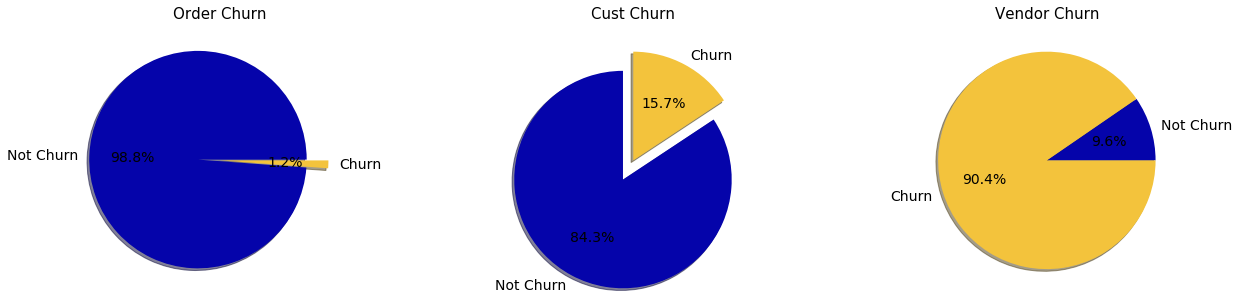

In [29]:
fig, (ax1, ax2, ax3)  = plt.subplots(1,3, figsize=(21, 5))

label = ['Not Churn', 'Churn']
label2 = ['Churn']
explode = (0.2,0)
ax1.pie(order_churn, explode=explode, labels=label, autopct='%1.1f%%', shadow=True, 
        textprops={'fontsize': 14,'color': 'black'}, colors = colors)
ax1.set_title('Order Churn', size=15)

ax2.pie(cust_churn, explode=explode, labels=label, autopct='%1.1f%%', shadow=True, 
        textprops={'fontsize': 14,'color': 'black'}, colors = colors, startangle=90)
ax2.set_title('Cust Churn', size=15)

ax3.pie(vendor_churn, labels=label, autopct='%1.1f%%', shadow=True, 
        textprops={'fontsize': 14,'color': 'black'}, colors = colors)
ax3.set_title('Vendor Churn', size=15)

plt.plot()

### EDA Churn Vs Not Churn

In [30]:
df.columns

Index(['akeed_order_id_x', 'customer_id', 'item_count', 'grand_total',
       'payment_mode', 'vendor_discount_amount',
       'promo_code_discount_percentage', 'vendor_rating', 'driver_rating',
       'deliverydistance', 'preparationtime', 'delivery_time',
       'order_accepted_time', 'driver_accepted_time', 'ready_for_pickup_time',
       'picked_up_time', 'delivered_time', 'delivery_date', 'vendor_id',
       'created_at', 'LOCATION_NUMBER', 'LOCATION_TYPE',
       'CID X LOC_NUM X VENDOR', 'date', 'favorite', 'Year-Month', 'Year',
       'Month', 'vendor_discount_amount2', 'akeed_order_id_y', 'Churn'],
      dtype='object')

In [31]:
grand_total_churn = df['grand_total'][df['Churn']==1]
grand_total_churn2 = df['grand_total'][(df['Churn']==1) & (df['grand_total']<100)]
grand_total_not = df['grand_total'][df['Churn']==0]
grand_total_not2 = df['grand_total'][(df['Churn']==0) & (df['grand_total']<100)]

[]

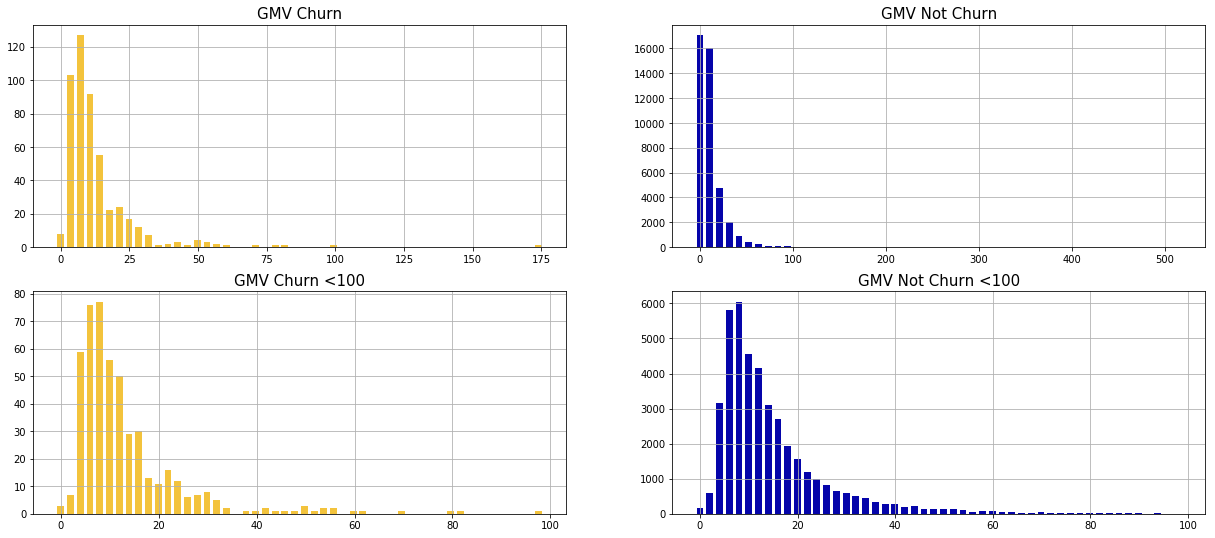

In [32]:
fig, ax  = plt.subplots(2,2, figsize=(21, 9))

ax[0,0].hist(grand_total_churn, bins=50, color='#f3c33c', rwidth=0.7, align='left')
ax[0,0].set_title('GMV Churn', size=15)
ax[0,0].grid(True)

ax[0,1].hist(grand_total_not, bins=50, color='#0504aa', rwidth=0.7, align='left')
ax[0,1].set_title('GMV Not Churn', size=15)
ax[0,1].grid(True)

ax[1,0].hist(grand_total_churn2, bins=50, color='#f3c33c', rwidth=0.7, align='left')
ax[1,0].set_title('GMV Churn <100', size=15)
ax[1,0].grid(True)

ax[1,1].hist(grand_total_not2, bins=50, color='#0504aa', rwidth=0.7, align='left')
ax[1,1].set_title('GMV Not Churn <100', size=15)
ax[1,1].grid(True)

plt.plot()

In [33]:
item_count_churn = df['item_count'][df['Churn']==1]
item_count_churn2 = df['item_count'][(df['Churn']==1) & (df['item_count']<10)]
item_count_not = df['item_count'][df['Churn']==0]
item_count_not2 = df['item_count'][(df['Churn']==0) & (df['item_count']<10)]

[]

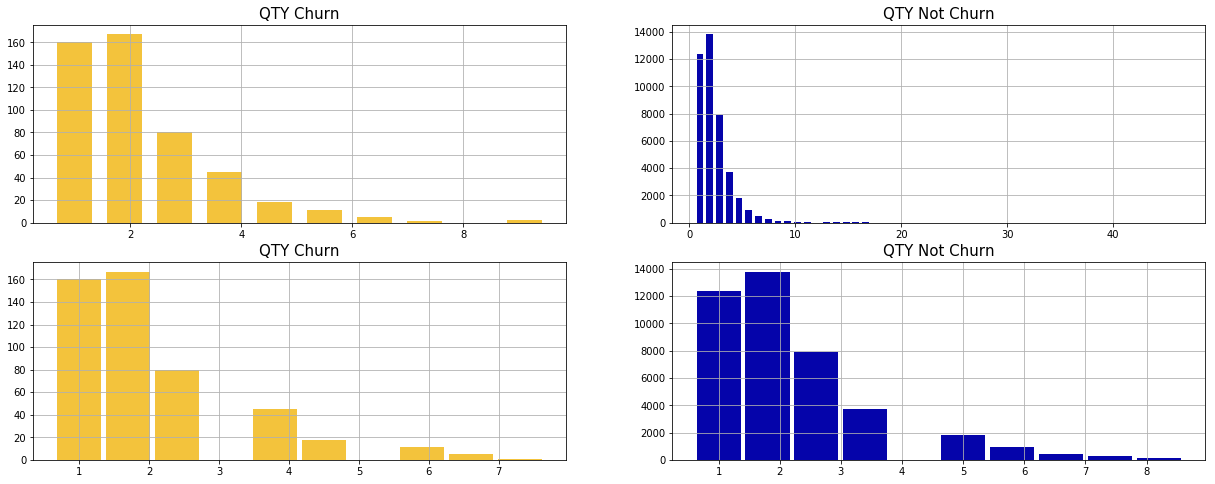

In [34]:
fig, ax  = plt.subplots(2,2, figsize=(21, 8))

ax[0,0].hist(item_count_churn, bins=10, color='#f3c33c', rwidth=0.7, align='left')
ax[0,0].set_title('QTY Churn', size=15)
ax[0,0].grid(True)

ax[0,1].hist(item_count_not, bins=50, color='#0504aa', rwidth=0.7, align='left')
ax[0,1].set_title('QTY Not Churn', size=15)
ax[0,1].grid(True)

ax[1,0].hist(item_count_churn2, color='#f3c33c', rwidth=0.9 , align='left')
ax[1,0].set_title('QTY Churn', size=15)
ax[1,0].grid(True)

ax[1,1].hist(item_count_not2, color='#0504aa', rwidth=0.9 , align='left')
ax[1,1].set_title('QTY Not Churn', size=15)
ax[1,1].grid(True)

plt.plot()

In [35]:
df[['promo_code_discount_percentage','vendor_discount_amount']][df['Churn']==1].describe()

,promo_code_discount_percentage,vendor_discount_amount
count,489.0,489.0
mean,0.0,0.0
std,0.0,0.0
min,0.0,0.0
25%,0.0,0.0
50%,0.0,0.0
75%,0.0,0.0
max,0.0,0.0


dari tabel di atas pun didapat bahwa customer churn sama sekali tidak menggunakan voucher. maka dari itu dapat disimpulkan bahwa, salah satu penyebab customer tidak membeli kembali yaitu karena orang terakhir mereka tidak menggunakan voucher

In [36]:
driver_rating_churn = df[['vendor_rating','driver_rating']][df['Churn']==1].groupby('driver_rating',as_index=False).count()
driver_rating_churn['driver_rating'] = driver_rating_churn['driver_rating'].astype(str)

driver_rating_not = df[['vendor_rating','driver_rating']][df['Churn']==0].groupby('driver_rating',as_index=False).count()
driver_rating_not['driver_rating'] = driver_rating_not['driver_rating'].astype(str)

[]

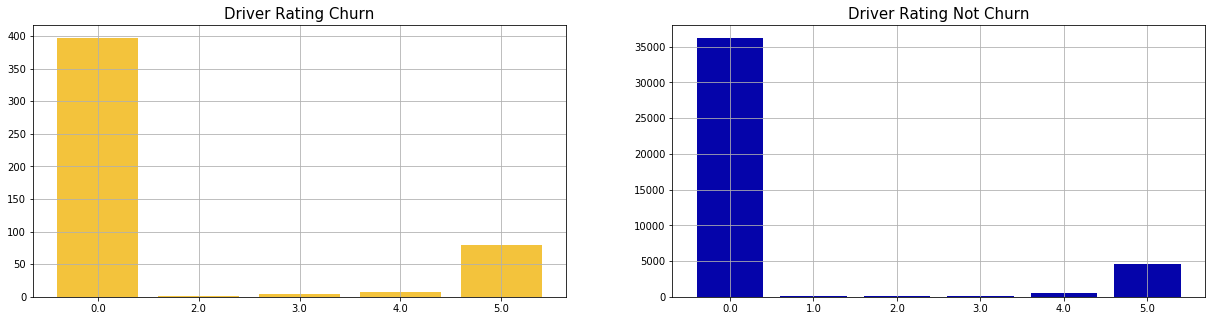

In [37]:
fig, (ax1, ax2)  = plt.subplots(1,2, figsize=(21, 5))

ax1.bar(driver_rating_churn['driver_rating'], driver_rating_churn['vendor_rating'], color='#f3c33c')
ax1.set_title('Driver Rating Churn', size=15)
ax1.grid(True)


ax2.bar(driver_rating_not['driver_rating'], driver_rating_not['vendor_rating'], color='#0504aa')
ax2.set_title('Driver Rating Not Churn', size=15)
ax2.grid(True)

plt.plot()

In [38]:
deliverydistance=df[df['deliverydistance']>=1]
deliverydistance_churn = deliverydistance['deliverydistance'][df['Churn']==1]
deliverydistance_not = deliverydistance['deliverydistance'][df['Churn']==0]

[]

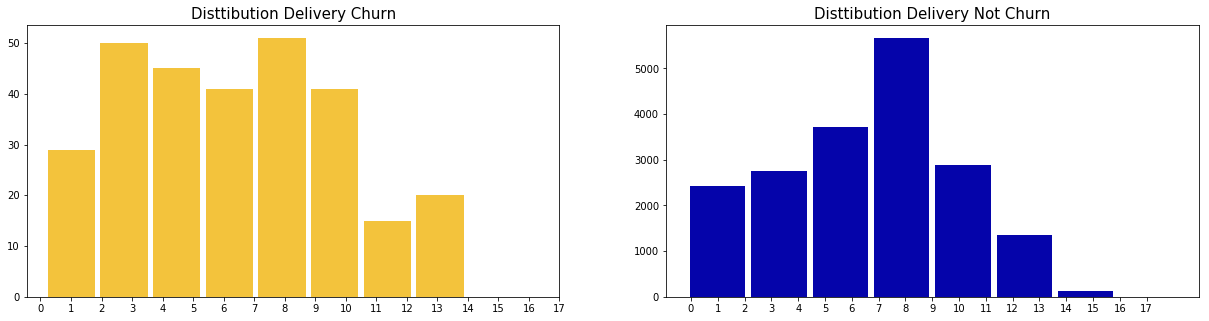

In [39]:
fig, (ax1,ax2)  = plt.subplots(1,2, figsize=(21, 5))

ax1.hist(deliverydistance_churn, bins=8, color='#f3c33c', rwidth=0.9, align='left')
ax1.set_title('Disttibution Delivery Churn', size=15)
ax1.set_xticks(np.arange(0, 18, 1))

ax2.hist(deliverydistance_not, bins=8, color='#0504aa', rwidth=0.9, align='left')
ax2.set_title('Disttibution Delivery Not Churn', size=15)
ax2.set_xticks(np.arange(0, 18, 1))

plt.plot()

In [40]:
preparationtime_churn = df[['preparationtime','driver_rating']][(df['Churn']==1) & 
                        (df['preparationtime']<999)].groupby('preparationtime',as_index=False).count()
preparationtime_churn['preparationtime'] = preparationtime_churn['preparationtime'].astype(str)

preparationtime_not = df[['preparationtime','driver_rating']][(df['Churn']==0) & 
                        (df['preparationtime']<999)].groupby('preparationtime',as_index=False).count()
preparationtime_not['preparationtime'] = preparationtime_not['preparationtime'].astype(str)

[]

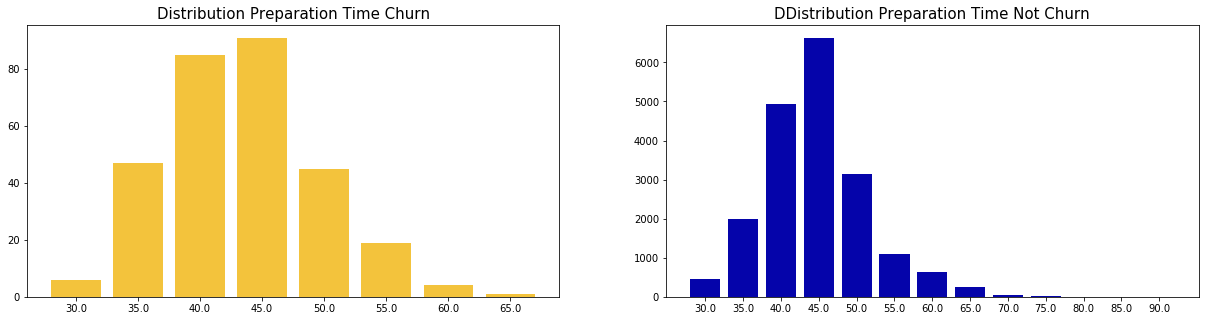

In [41]:
fig, (ax1, ax2)  = plt.subplots(1,2, figsize=(21, 5))

ax1.bar(preparationtime_churn['preparationtime'], preparationtime_churn['driver_rating'], color='#f3c33c')
ax1.set_title('Distribution Preparation Time Churn', size=15)

ax2.bar(preparationtime_not['preparationtime'], preparationtime_not['driver_rating'], color='#0504aa')
ax2.set_title('DDistribution Preparation Time Not Churn', size=15)

plt.plot()

### Vendor Churn EDA

In [42]:
vendor_cust = df[['vendor_id','Churn','customer_id']].groupby(['vendor_id','customer_id'],as_index=False).sum()
vendor_cust['Churn']=vendor_cust['Churn'].apply(lambda x: 1 if x>1 else x)
vendor_cust = vendor_cust[['vendor_id','Churn']].groupby('vendor_id', as_index=False).sum()

vendor_cust_count = df[['vendor_id','Churn','customer_id']].groupby(['vendor_id','customer_id'],as_index=False).sum()
vendor_cust_count = vendor_cust_count[['vendor_id','customer_id']].groupby('vendor_id', as_index=False).count()

In [43]:
percentage_vendor_cust = vendor_cust.merge(vendor_cust_count, on=['vendor_id'], how='left')
percentage_vendor_cust.rename(columns={'customer_id': 'customer'}, inplace=True)
percentage_vendor_cust['percentage churn']=percentage_vendor_cust['Churn']/percentage_vendor_cust['customer']*100
percentage_vendor_cust.describe()

,vendor_id,Churn,customer,percentage churn
count,94.000000,94.000000,94.000000,94.000000
mean,252.436170,5.202128,186.276596,2.566776
std,200.352676,6.756247,124.061414,2.177579
min,4.000000,0.000000,1.000000,0.000000
25%,104.250000,2.000000,109.250000,1.178211
50%,196.500000,4.000000,150.000000,2.385084
75%,302.250000,6.000000,234.750000,3.296087
max,858.000000,44.000000,649.000000,15.384615
